In [45]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *

#Interactive graph modules
# %matplotlib notebook
from ipywidgets import *

In [46]:
#Configure simulation paratmers
#Geometric Parameters
r_max = 0.3 # maximum radial distance of simulation (m)
n = 2*600 #surface discretisation
g = 9.81 # gravitational constant

#Time parameters
t_count = int(5000) #number of timesteps
update_freq = t_count/10
t_max = 1
t = np.linspace(0, t_max, t_count) #time vector


In [47]:
#Set exhast gas parameters (fuel mixture estimate)
R = 8.314/0.028 #[J/mol·K] universal gas constant, normalized by molar mass
gamma = 1.4 # heat capacity ratio
mu_c = 17.49E-6 #[Pa.s] #viscosity in the rocket chamber

In [48]:
#Configure the surface geology parameters
D = (109) *1e-6 #diameter of dust particles (microns)
c = 0.6 #packing concentration in dust layer
sigma = 2500 #[kg/m3]density of dust particle

A_coh = 0 #cohesional shear stress (experimental)
tau_coh = 0 #cohesional shear stress (experimental)
alpha = (20)*np.pi/180 #static angle of repose of cohensionless particles (deg)
alpha_collapse = (25)*np.pi/180 #angle of repose at which avalanche start (deg)

K = 1 # shear stress augmentation factor

In [49]:
#Set rocket engine parameters
r_e = 0.005 #[m] nozzle radius exit
M_e = 5 #nozzle exit mach number
p_c = 1.25e6 #[Pa] rocket chamber pressure (max pressure)
T_c = 300 #[K] #temperature in the rocket chamber
h = 0.1 #[m] nozzle height above surface

In [50]:
#Initialize arrays for data storage
# r = np.linspace(-r_max, -min(downrange) + r_max, n) #radial positions
r1 = np.linspace(-r_max, r_max, n) # simulation x-axis 
dr = abs(r1[0]-r1[1])

y = np.zeros(shape=(n, len(t))) #surface elevation vector
dy_dt = np.zeros(shape=(n, len(t))) #mass flow rate vector
tau = np.zeros(shape=(n, len(t))) #surface shear

#p_g = np.zeros(shape=(n, 1)) #initial group pressure

In [51]:
def moving_average(array_var, n_pt=3):
    ret = np.cumsum(array_var, dtype=float)
    ret[n_pt:] = ret[n_pt:] - ret[:-n_pt]
    return ret[n_pt - 1:] / n_pt

In [52]:
# ini_pos = downrange[0]
def simulate():    
    #Loop through simulation time
    for i in range(1, len(t)):
        # shift = downrange[i] - downrange[i-1]
        # for j in range(len(r)):
        #     r[j] += shift
        theta = np.arctan(r1/h)
        beta = np.arctan(np.diff(np.transpose(y[:,i-1]))/dr)
        beta = np.insert(beta, 0, 0)    
        #Calculate derived values
        k = gamma*(gamma-1)*M_e**2 #hypersonic simularity parameter
        p_r = p_c*(1+gamma*M_e**2)/(1+(gamma-1)/2*M_e**2)**(gamma/(gamma-1)) #post-shock recovery pressure without inverse-square propagation
        p_s = np.minimum(p_r,(k+2)/2*(r_e/h)**2*p_r) #post-shock centerline pressure with inverse-square propagation
        p = p_s*np.cos(theta)**(k+4)*np.cos(beta)**2*(1-np.tan(theta)*np.tan(beta))**2 #ground pressure
        u = np.sqrt(2*gamma/(gamma-1)*R*T_c*(1-(p/p_s)**((gamma-1)/gamma))) #velocity parallel to surface
        q = (gamma/(gamma-1))*(1-(p/p_s)**((gamma-1)/gamma))*(p/p_s)**(1/gamma)*p_s #dynamic pressure
        rho = 2*q/(np.square(u)) #density
        mu = mu_c*(p/p_s)**((gamma-1)/(2*gamma)) #gas viscosity

        #Reynolds Numbers
        Re_D = rho*u*D/mu #particle Reynold number
        Re_theta = rho*u*r1/mu #surface Reynold number

        #Fluid Coefficents
        C_d = 24/Re_D #+ 3/Re_D**2 +0.34 #friction coefficient of particles
        C_f = 0.84 #friction coefficient of surface

        #Calculated derived values continued
        tau[:,i] = K*C_f*q #surface shear
        tau_star = sigma*c*D*g*(np.cos(beta)*np.tan(alpha) - np.sin(beta)) + A_coh*D**(-3) + tau_coh #shear retaining stress
        Xi = 18*mu_c*h/(sigma*D**2*np.sqrt(R*T_c*(k+4)))*(1+((k+2)*D*C_d*p_r)/(72*np.sqrt(2)*mu_c*np.sqrt(R*T_c))*(r_e/h)**2) #goes inside the momentum factor
        a = 1/(0.5 + np.sqrt( 0.25 + (1/Xi) )) #momentum factor

        #Calculate erosion rate
        dy_dt[:,i] = 2*(tau[:,i]-tau_star)/(a*u*sigma*c*np.cos(beta)) # erosion rate
        dy_dt[:,i] = np.nan_to_num(dy_dt[:,i])

        #Apply errosion
        y[:,i] = y[:,i-1]-dy_dt[:,i]*(t[i]-t[i-1]) #surface modification due to erosion, forward euler scheme
        y[0,i] = y[1,i] #correcting for zero erosion at centerline.

        if True:
            y_minslope = y[:,i]
            beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/dr)
            beta_minslope = np.insert(beta, 0, 0)
            while max(abs(beta_minslope)) > alpha_collapse:
                for k in range(len(y_minslope)-1):
                    local_slope = np.arctan((y_minslope[k+1]-y_minslope[k])/dr)
                    if abs(local_slope)>alpha_collapse:
                        mid_point = (y_minslope[k+1] + y_minslope[k])/2
                        y_minslope[k] = mid_point - np.sign(local_slope)*alpha*(0.5*dr)
                        y_minslope[k+1] = mid_point + np.sign(local_slope)*alpha*(0.5*dr)
                beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/dr)
                beta_minslope = np.insert(beta_minslope, 0, 0)
            y[:,i] = y_minslope
        else:
            #Simple 3-point filtering
            y_filt = moving_average(np.concatenate((np.flip(y[:,i]), y[:,i])))
            y[:,i] = np.flip(y_filt[0:n])

        #Print time update
        if (i%update_freq ==0):
            print(str(i)+' of '+str(len(t)))
    
    #Return the erosion history
    return y

In [53]:
y = np.zeros(shape=(n, len(t))) #surface elevation vector
y_sim_na = simulate()

500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000


In [54]:
n = 600
r2 = np.linspace(0,r_max,n)
dr = r_max/n
# ini_pos = downrange[0]
def simulate():    
    #Loop through simulation time
    for i in range(1, len(t)):
        # shift = downrange[i] - downrange[i-1]
        # for j in range(len(r)):
        #     r[j] += shift
        theta = np.arctan(r2/h)
        beta = np.arctan(np.diff(np.transpose(y[:,i-1]))/dr)
        beta = np.insert(beta, 0, 0)    
        #Calculate derived values
        k = gamma*(gamma-1)*M_e**2 #hypersonic simularity parameter
        p_r = p_c*(1+gamma*M_e**2)/(1+(gamma-1)/2*M_e**2)**(gamma/(gamma-1)) #post-shock recovery pressure without inverse-square propagation
        p_s = np.minimum(p_r,(k+2)/2*(r_e/h)**2*p_r) #post-shock centerline pressure with inverse-square propagation
        p = p_s*np.cos(theta)**(k+4)*np.cos(beta)**2*(1-np.tan(theta)*np.tan(beta))**2 #ground pressure
        u = np.sqrt(2*gamma/(gamma-1)*R*T_c*(1-(p/p_s)**((gamma-1)/gamma))) #velocity parallel to surface
        q = (gamma/(gamma-1))*(1-(p/p_s)**((gamma-1)/gamma))*(p/p_s)**(1/gamma)*p_s #dynamic pressure
        rho = 2*q/(np.square(u)) #density
        mu = mu_c*(p/p_s)**((gamma-1)/(2*gamma)) #gas viscosity

        #Reynolds Numbers
        Re_D = rho*u*D/mu #particle Reynold number
        Re_theta = rho*u*r2/mu #surface Reynold number

        #Fluid Coefficents
        C_d = 24/Re_D #+ 3/Re_D**2 +0.34 #friction coefficient of particles
        C_f = 0.84 #friction coefficient of surface

        #Calculated derived values continued
        tau[:,i] = K*C_f*q #surface shear
        tau_star = sigma*c*D*g*(np.cos(beta)*np.tan(alpha) - np.sin(beta)) + A_coh*D**(-3) + tau_coh #shear retaining stress
        Xi = 18*mu_c*h/(sigma*D**2*np.sqrt(R*T_c*(k+4)))*(1+((k+2)*D*C_d*p_r)/(72*np.sqrt(2)*mu_c*np.sqrt(R*T_c))*(r_e/h)**2) #goes inside the momentum factor
        a = 1/(0.5 + np.sqrt( 0.25 + (1/Xi) )) #momentum factor

        #Calculate erosion rate
        dy_dt[:,i] = 2*(tau[:,i]-tau_star)/(a*u*sigma*c*np.cos(beta)) # erosion rate
        dy_dt[:,i] = np.nan_to_num(dy_dt[:,i])

        #Apply erosion
        y[:,i] = y[:,i-1]-dy_dt[:,i]*(t[i]-t[i-1]) #surface modification due to erosion, forward euler scheme
        y[0,i] = y[1,i] #correcting for zero erosion at centerline.

        if True:
            r_total = np.concatenate((-np.flip(r2), r2))
            y_minslope = np.concatenate((np.flip(y[:,i]), y[:,i]))
            beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/dr)
            beta_minslope = np.insert(beta, 0, 0)
            while max(abs(beta_minslope)) > alpha_collapse:
                for k in range(len(y_minslope)-1):
                    local_slope = np.arctan((y_minslope[k+1]-y_minslope[k])/dr)
                    if abs(local_slope)>alpha_collapse:
                        mid_point = (y_minslope[k+1] + y_minslope[k])/2
                        y_minslope[k] = mid_point - np.sign(local_slope)*alpha*(0.5*dr)
                        y_minslope[k+1] = mid_point + np.sign(local_slope)*alpha*(0.5*dr)
                beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/dr)
                beta_minslope = np.insert(beta_minslope, 0, 0)
            y[:,i] = np.flip(y_minslope[0:n])
        else:
            #Simple 3-point filtering
            y_filt = moving_average(np.concatenate((np.flip(y[:,i]), y[:,i])))
            y[:,i] = np.flip(y_filt[0:n])

        #Print time update
        if (i%update_freq ==0):
            print(str(i)+' of '+str(len(t)))
    
    #Return the erosion history
    return y

In [55]:
y = np.zeros(shape=(n, len(t))) #surface elevation vector
dy_dt = np.zeros(shape=(n, len(t))) #mass flow rate vector
tau = np.zeros(shape=(n, len(t))) #surface shear
y_sim_as = simulate()

C:\Users\ishaa\AppData\Local\Temp\ipykernel_31592\570713826.py:21: RuntimeWarning: invalid value encountered in divide
  rho = 2*q/(np.square(u)) #density


500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000


In [56]:
# np.linspace(10,100,10)

In [57]:
# h_arr = np.linspace(10,100,10)*(r_e*2) # From 10 to 100 h/d in (m)
# final_crater = np.zeros((n,len(h_arr)))
# for chef,h in enumerate(h_arr):
#     y = np.zeros(shape=(n, len(t))) #surface elevation vector
#     dy_dt = np.zeros(shape=(n, len(t))) #mass flow rate vector
#     tau = np.zeros(shape=(n, len(t))) #surface shear
#     y_sim_as = simulate(h)
#     final_crater[:,chef] = y_sim_as[:,-1]

In [58]:
# from matplotlib.animation import FuncAnimation
# import matplotlib as mpl
# import matplotlib.animation as ani

# mpl.rcParams['animation.ffmpeg_path'] = r"C:\Users\ishaa\Downloads\ffmpeg-master-latest-win64-gpl-shared\ffmpeg-master-latest-win64-gpl-shared\bin\ffmpeg.exe"

# No Axial Symmetry

In [59]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# # ax.set_xlim(-25,25)
# # ax.set_ylim(-0.002,0.0001)
# ax.set_xlabel("Horizontal Position (m)")
# ax.set_ylabel("Vertical Position (m)")
# plt.title("Static Nozzle - No Assumptions - Simulation")
# plt.grid()

# # np.concatenate((-np.flip(r), r))
# # np.concatenate((np.flip(y_sim[:,0]), y_sim[:,0]))

# line, = ax.plot(r1, y_sim_na[:,0], "k")
# def update(frame):
#     line.set_data(r1, y_sim_na[:,frame])
#     return line,

# # Create the animation
# animation = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)
# plt.show()
# f = r"Animations/crater-no_ar.mp4" 
# writervideo = ani.FFMpegWriter(fps=50) 
# animation.save(f, writer=writervideo)

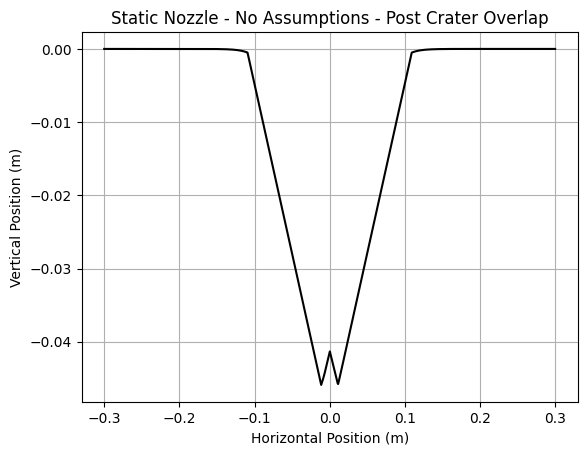

In [60]:
plt.figure()
plt.xlabel("Horizontal Position (m)")
plt.ylabel("Vertical Position (m)")
plt.title("Static Nozzle - No Assumptions - Post Crater Overlap")
plt.grid()
plt.plot(r1, y_sim_na[:,-1], "k")
# plt.legend()

# Mirrored

In [61]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# # ax.set_xlim(-25,25)
# # ax.set_ylim(-0.002,0.0001)
# ax.set_xlabel("Horizontal Position (m)")
# ax.set_ylabel("Vertical Position (m)")
# plt.title("Static Nozzle - Mirrored Simulation")
# plt.grid()

# line, = ax.plot(np.concatenate((-np.flip(r2), r2)), np.concatenate((np.flip(y_sim_as[:,0]), y_sim_as[:,0])), "k")
# def update(frame):
#     line.set_data(np.concatenate((-np.flip(r2), r2)), np.concatenate((np.flip(y_sim_as[:, frame]), y_sim_as[:,frame])))
#     return line,

# # Create the animation
# animation = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)
# plt.show()
# f = r"Animations/crater-mirror-no_ar.mp4" 
# writervideo = ani.FFMpegWriter(fps=50) 
# # animation.save(f, writer=writervideo)

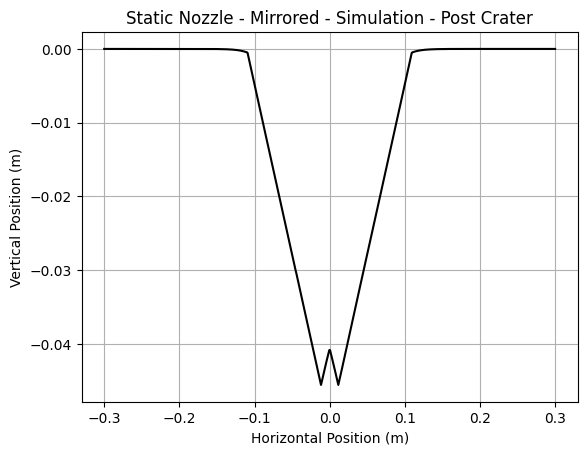

In [62]:
plt.figure()
plt.xlabel("Horizontal Position (m)")
plt.ylabel("Vertical Position (m)")
plt.title("Static Nozzle - Mirrored - Simulation - Post Crater")
plt.grid()
plt.plot(np.concatenate((-np.flip(r2), r2)), np.concatenate((np.flip(y_sim_as[:,-1]), y_sim_as[:,-1])), "k")
# plt.legend()

# Overlap

In [63]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# # ax.set_xlim(-25,25)
# # ax.set_ylim(-0.004,0.001)
# ax.set_xlabel("Horizontal Position (m)")
# ax.set_ylabel("Vertical Position (m)")
# plt.title("Static Nozzle Simulation")
# plt.grid()

# line1, = ax.plot(r1, y_sim_na[:,0], "g", label="No assumptions")
# line2, = ax.plot(np.concatenate((-np.flip(r2), r2)), np.concatenate((np.flip(y_sim_as[:,0]), y_sim_as[:,0])), "y", label="Axial Symmetry")
# ax.legend()
# def update(frame):
#     line1.set_data(r1, y_sim_na[:,frame])
#     line2.set_data(np.concatenate((-np.flip(r2), r2)), np.concatenate((np.flip(y_sim_as[:, frame]), y_sim_as[:,frame])))
#     return line1,line2

# # Create the animation
# animation = FuncAnimation(fig, update, frames=len(t), interval=50, blit=True)
# plt.show()
# f = r"Animations/crater-overlap3.mp4" 
# writervideo = ani.FFMpegWriter(fps=50) 
# # animation.save(f, writer=writervideo)

In [70]:
file_lab = r"../Lab Craters/2023_08_07_50mTorr_h10_860gs_crater16_X-Slice.csv"
arr_lab = np.loadtxt(file_lab,delimiter=",")
x_lab = arr_lab[:,0]/1000
z_lab = arr_lab[:,2]/1000
z_lab = z_lab - 0.031

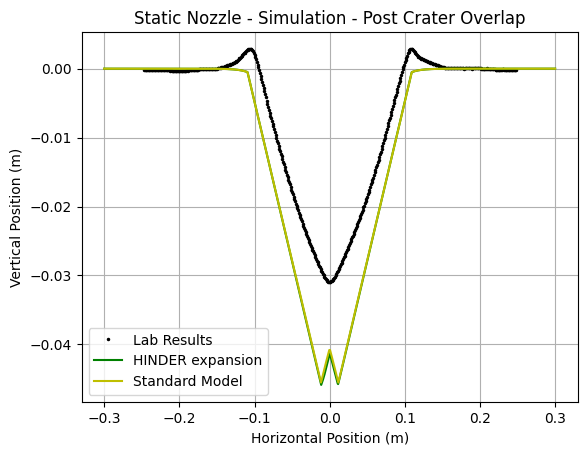

In [72]:
plt.figure()
plt.xlabel("Horizontal Position (m)")
plt.ylabel("Vertical Position (m)")
plt.title("Static Nozzle - Simulation - Post Crater Overlap")
plt.grid()
plt.plot(x_lab,z_lab,"k.", markersize=3, label="Lab Results")
plt.plot(r1, y_sim_na[:,-1], "g", label="HINDER expansion")
plt.plot(np.concatenate((-np.flip(r2), r2)), np.concatenate((np.flip(y_sim_as[:,-1]), y_sim_as[:,-1])), "y", label="Standard Model")
plt.legend()